In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from src.model import GBModel
import pandas as pd
import numpy as np
import pickle
from src.cleaner import Cleaner
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
from src.util import *

In [2]:
df = pd.read_pickle('data/pickled_df')
ticket_types = pd.read_pickle('data/ticket_types')
df['fraud'] = df.acct_type.str.contains('fraud').astype(int)
df['spam'] = df.acct_type.str.contains('spam').astype(int)

# Fraud Rate

In [3]:
fraud_rate = (df.fraud==1).sum()/len(df)
print('The rate of Fraud is: {}'.format(fraud_rate))

The rate of Fraud is: 0.09018623142916929


# EDA

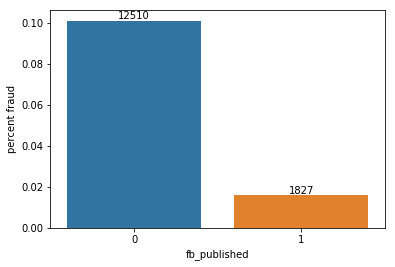

In [4]:
barplotter(df, 'fb_published')

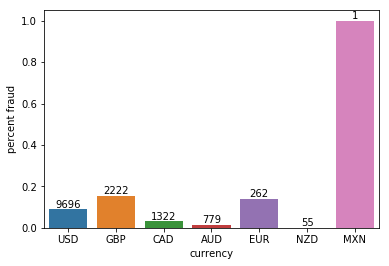

In [5]:
barplotter(df, 'currency')

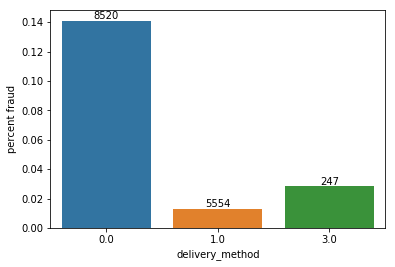

In [6]:
# delivery method
barplotter(df, 'delivery_method')

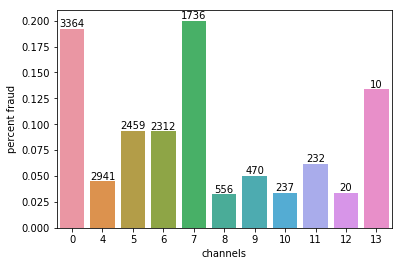

In [7]:
barplotter(df, 'channels')

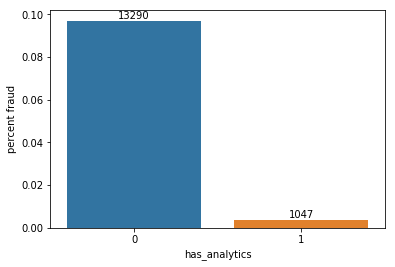

In [8]:
barplotter(df,'has_analytics')

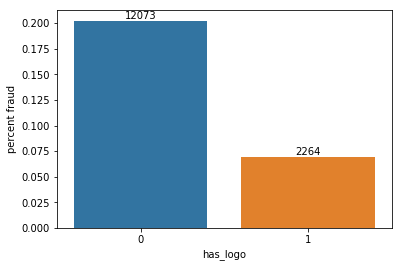

In [9]:
barplotter(df,'has_logo')

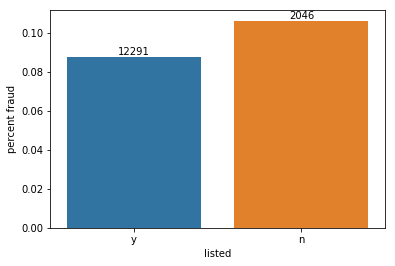

In [10]:
barplotter(df, 'listed')

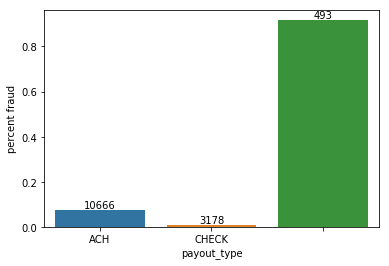

In [11]:
barplotter(df, 'payout_type')

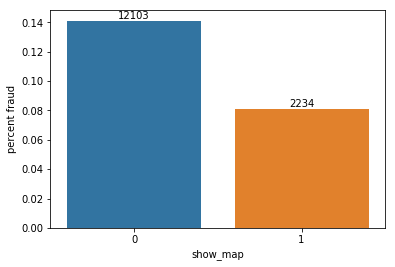

In [12]:
barplotter(df, 'show_map')

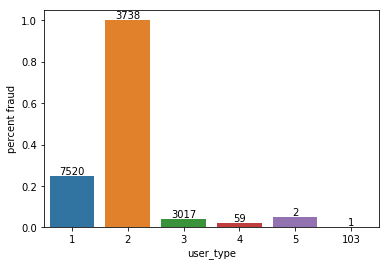

In [13]:
barplotter(df, 'user_type')

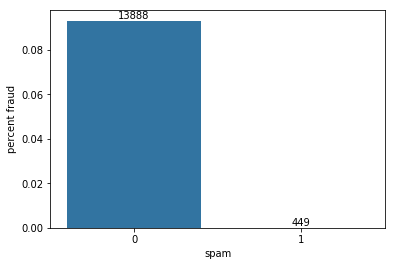

In [14]:
barplotter(df, 'spam')

# Clean Data

In [15]:
clean = Cleaner()
clean.fit(df)
X = clean.transform(df)

Rating risk...


/Users/kylecaron/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:951: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Risk ratings complete
Written to pickle!


## Create a function to Clean Categorical Data

This function creates dictionaries for cleaning that can be used to quickly reduce columns with thousands of categories into just 5 categories grouped by level of risk. 

In [16]:
def get_risk_dict(df, col):
    bad_accts = ['fraudster_event','fraudster','fraudster_att']
    fraud_thresholds = [0.07,0.12,0.2,0.5]
    risk_dict = {}
    for field in df[col].value_counts().index:
        if len([x for x in bad_accts if x in df[df[col]==field]['acct_type'].value_counts().index]) >0:
            fraud_rate = df[df[col]==field]['acct_type'].value_counts()[bad_accts].sum()/\
                df[df[col]==field]['acct_type'].value_counts().sum()
            risk = len(fraud_thresholds)
            for i in range(risk):
                if fraud_rate < fraud_thresholds[i]:
                    risk = i;break
            risk_dict[field]=risk
        else:
            risk_dict[field]=0
    return risk_dict

In [17]:
X.head()

,org_facebook,org_twitter,user_type_risk,email_domain_risk,venue_state_risk,channels_risk,currency_risk,delivery_method_risk,payout_type_risk,venue_address_risk,body_length,channels,gts,fb_published,has_analytics,has_header,has_logo,name_length,num_order,num_payouts,sale_duration,sale_duration2,show_map,user_age,listed,avg_payout,num_payees,tickets_available,value_sold,value_available,max_price
object_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
527017,0.0,0.0,3,1,3.0,1,1,2.0,4,4,3852,5,0.00,0,0,1.0,0,60,0,0,29.0,33,1,36,1,0.000000,0,1,0.00,36000.00,550.00
786878,0.0,12.0,0,0,0.0,2,1,0.0,0,3,3499,0,868.02,0,0,0.0,1,27,23,1,28.0,28,0,149,0,16394.364490,1,1,875.00,3500.00,35.00
787337,0.0,0.0,0,0,0.0,0,1,0.0,0,0,2601,8,3500.00,0,0,0.0,0,28,19,4,54.0,54,0,214,1,1508.400000,5,1,4488.48,4488.48,93.51
885645,0.0,0.0,0,0,0.0,1,2,0.0,1,3,12347,6,1167.35,0,0,0.0,1,21,39,16,0.0,0,0,889,1,208.779524,1,1,795.00,410000.00,25.00
1114349,0.0,0.0,0,0,0.0,0,1,2.0,0,0,2417,11,2313.15,1,0,0.0,0,66,30,0,63.0,63,0,35,1,263.571837,2,1,2399.00,28596.00,200.00


# Optimizing Model with Grid Search

In [18]:
with open('data/model.pkl', 'rb') as f:
    GB = pickle.load(f)

In [19]:
clean = Cleaner()
df2 = df.copy()
y = df2.pop('fraud')

X_train, X_test, y_train, y_test = \
        train_test_split(df2, y, random_state = 142)

clean.fit(X_train)

Rating risk...
Risk ratings complete
Written to pickle!


In [20]:
X_train = clean.transform(X_train)
X_test = clean.transform(X_test)

### Set Parameter Grid

In [23]:
# X_train, X_test, y_train, y_test = \
#         train_test_split(X.values, y, random_state = 142)

gb_grid = {'learning_rate':[0.001,0.01],
          'max_depth':[4, 6, 9, 12],
          'min_samples_leaf':[1,3,4],
          'n_estimators':[1200,1500,2500],
          'max_features':[3,5,6]}

rf_grid = {'max_depth':[6,8,10,12],
          'min_samples_leaf':[1,3,4],
          'n_estimators':[500,1500,2500],
          'max_features':['auto','log2']}

### Run Grid Search

In [24]:
gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                             gb_grid, cv=3,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
gb_gridsearch.fit(X_train, y_train)
print( "best parameters:", gb_gridsearch.best_params_ )

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.8min
/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to 

best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 3, 'n_estimators': 2500}


In [25]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             rf_grid, cv=3,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
rf_gridsearch.fit(X_train, y_train)
print( "best parameters:", rf_gridsearch.best_params_ )

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  8.4min finished


best parameters: {'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 2500}


# Best Model Scores, Stage Score Plots

In [26]:
best_gb_model = gb_gridsearch.best_estimator_
best_rf_model = rf_gridsearch.best_estimator_

best_gb_model.fit(X_train,y_train)
best_rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
print('Gradient Boosting MSE: {}'.format(
    mean_squared_error(y_test, best_gb_model.predict(X_test))))
print('Gradient Boosting Accuracy Score: {}'.format(
    best_gb_model.score(X_test,y_test)))

print('Random Forest MSE: {}'.format(
    mean_squared_error(y_test, best_rf_model.predict(X_test))))
print('Random Forest Accuracy Score: {}'.format(
    best_rf_model.score(X_test,y_test)))

Gradient Boosting MSE: 0.04490934449093445
Gradient Boosting Accuracy Score: 0.9550906555090656
Random Forest MSE: 0.045188284518828455
Random Forest Accuracy Score: 0.9548117154811715


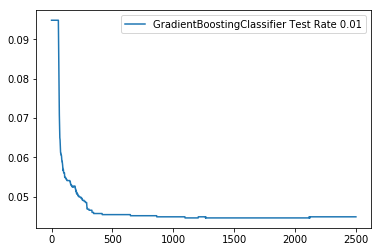

In [28]:
stage_score_plot(best_gb_model, X_train, y_train, X_test, y_test)
#stage_score_plot(best_rf_model, X_train, y_train, X_test, y_test)

### Params from best models

In [29]:
best_gb_model.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=2500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)>

In [30]:
best_rf_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

# Confusion matrix

In [31]:
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization
[[3241    4]
 [ 157  183]]


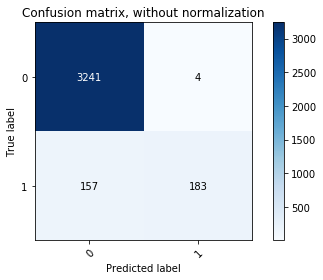

In [32]:
plot_confusion_matrix(y_test, best_gb_model.predict(X_test))

Confusion matrix, without normalization
[[3241    4]
 [ 158  182]]


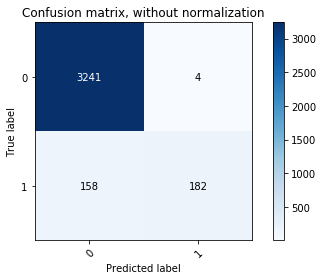

In [33]:
plot_confusion_matrix(y_test, best_rf_model.predict(X_test))

# ROC Curve

In [34]:
from sklearn.metrics import roc_curve

In [35]:
fpr, tpr, thresholds = roc_curve(
    y_test, best_gb_model.predict_proba(X_test)[:,1])

fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test, best_rf_model.predict_proba(X_test)[:,1])

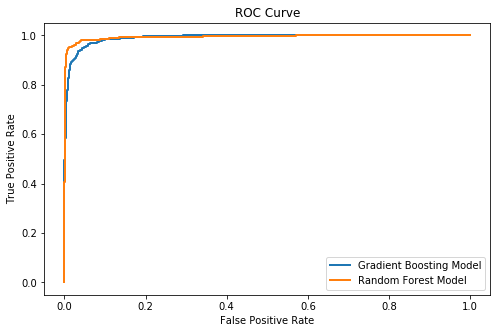

In [43]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(fpr, tpr, lw=2, alpha=1,label='Gradient Boosting Model')
ax.plot(fpr_rf, tpr_rf, lw=2, alpha=1,label='Random Forest Model')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, best_gb_model.predict(X_test)))
print(roc_auc_score(y_test,best_rf_model.predict(X_test)))

0.7685013142391007
0.7670307260038067


## Choosing a Model

As shown by the ROC Curve, the __Random Forest model__ is better performing for this fraud detection case due to its good performance with a low false positive rate, despite the Gradient Boosting model having a higher area under the curve. 

For something such as fraud detection, a high false positive rate can be damaging. With a high false positive rate, many customers event postings would incorrectly be labelled as fraud, which would prevent many people from selling tickets to thei events.

# Investigating the Model

In [65]:
with open('data/model.pkl', 'rb') as f:
    RF = pickle.load(f)

In [39]:
clean = Cleaner()
df2 = df.copy()
y = df2.pop('fraud')
clean.fit(df2)
X = clean.transform(df2)

Rating risk...


/Users/kylecaron/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:951: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Risk ratings complete
Written to pickle!


In [81]:
# Accuracy score
best_rf_model.score(X_test,y_test)

0.9548117154811715

## Feature Importance

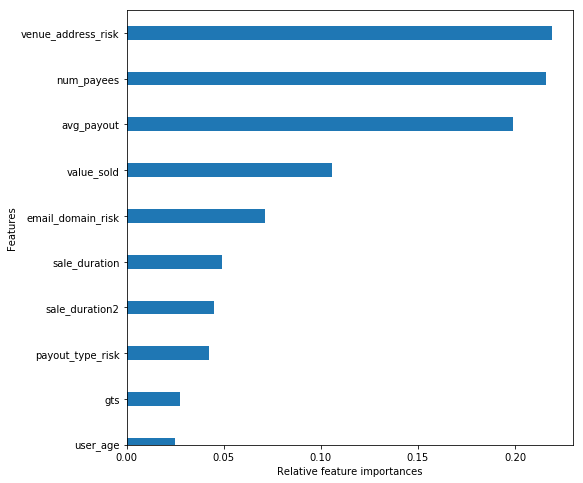

In [66]:
cols = list(X.columns)
RF.importance(cols)

# Partial Dependence Plots

Partial dependence plots are useful to interpret results from complicated classificaiton models. The partial dependence plots for the Gradient Boosting models top 10 most important features were shown below. This was not done for the better performing Random Forest model due to lack of support in Sklearn's library

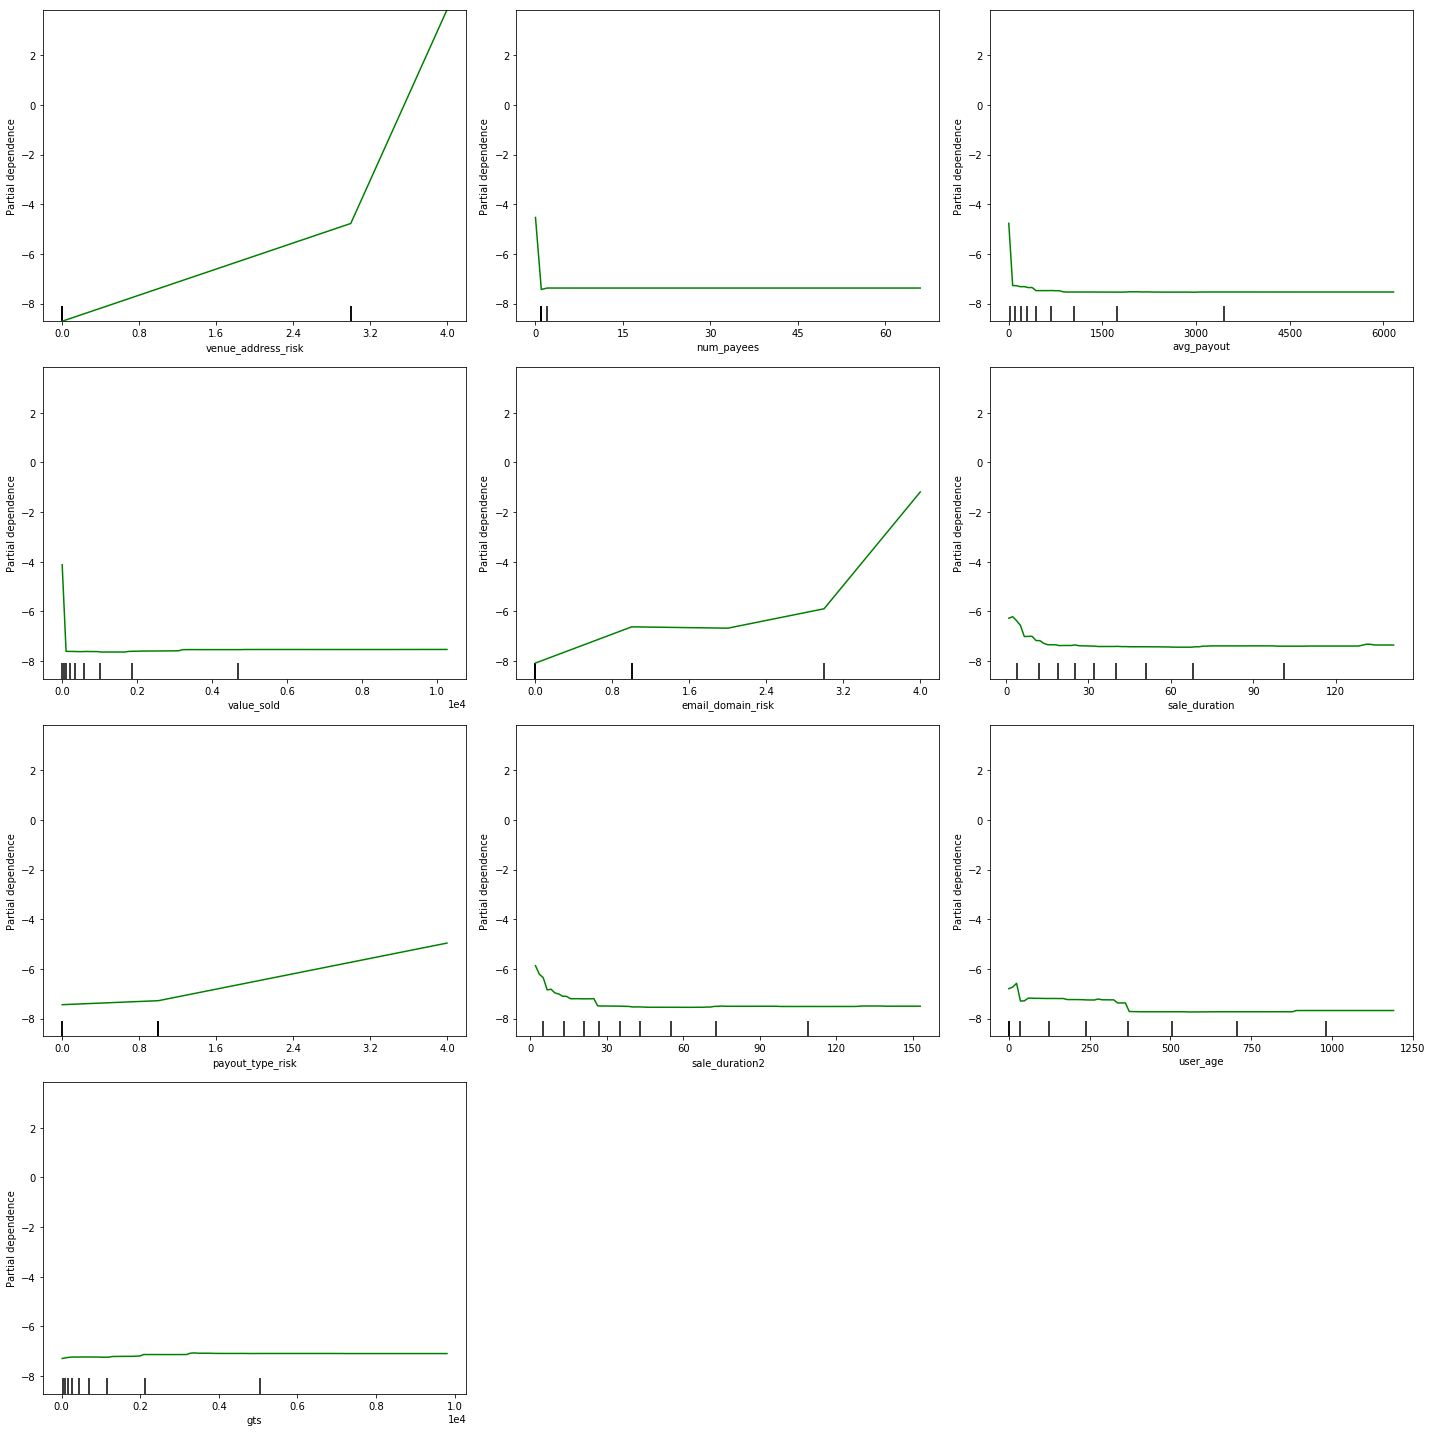

In [80]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
feature_importances = best_gb_model.feature_importances_

top10_colindex = np.argsort(feature_importances)[::-1][0:10]
#fig, axs = plt.subplots(5,2, figsize=(20,20))
fig, axs = plot_partial_dependence(best_gb_model, X_train, features=top10_colindex, 
feature_names = cols, figsize=(20,20), grid_resolution=100)

fig.set_figwidth(20)
fig.set_figheight(20)
fig.tight_layout()


#plot_partial_dependence(best_gb_model, X_train, cols)